In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from astropy.io import fits

In [3]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [4]:
from scipy.ndimage.filters import gaussian_filter

In [5]:
figsize(8,6)

In [6]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [84]:
def get_data(bank='A', session=5):
    fnames = glob.glob('/data2/GBT/S140/Daisy/*/*_0'+str(session)+'_*'+bank+'*.rfireduced_new.npz')
    fnames.sort()
    calibrations = np.load('/home/mabitbol/GBT-S140/calibrations/calibration_3C295_0'+str(session)+'_'+bank+'.npy').item()
    fdiode = calibrations['freqs']
    pdiode = calibrations['pdiode']
    pdiode1 = calibrations['pdiode1']
    meanpower = 0.5 * (pdiode + pdiode1)
    calibrated = np.ones((0, 512))
    ras = []
    decs = []
    azs = []
    els = []
    gains = np.ones((0, 512))
    for fname in fnames:
        nz = np.load(fname)
        ra = nz['sra']
        dec = nz['sdec']
        mask = nz['valid']
        az = nz['AZIMUTH'][::8]
        el = nz['ELEVATIO'][::8]
        freqs = nz['freqs']
        
        
        gain = meanpower / (nz['xxon'] - nz['xxoff'])
        calibd = nz['xxoff'] * gain
        mask[:200] = False
        mask[400:] = False
        calibd[:, ~mask] = np.nan
        gain[:, ~mask] = np.nan
        
        calibrated = np.concatenate([calibrated, calibd - np.nanmedian(calibd, 0)], axis=0)
        gains = np.concatenate([gains, gain], axis=0)

        ras = np.concatenate([ras, ra])
        decs = np.concatenate([decs, dec])
        azs = np.concatenate([azs, az])
        els = np.concatenate([els, el])
    return calibrated, gains, ras, decs, azs, els

In [85]:
calibrated, gains, ra, dec, azs, els = get_data('A')

In [10]:
ts = np.arange(len(calibrated))
tmask = (ts < 42000) | (ts > 50000 )

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


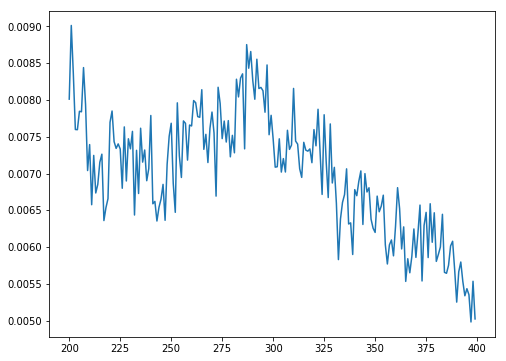

In [11]:
plot(np.nanmean(calibrated[tmask,:], 0))

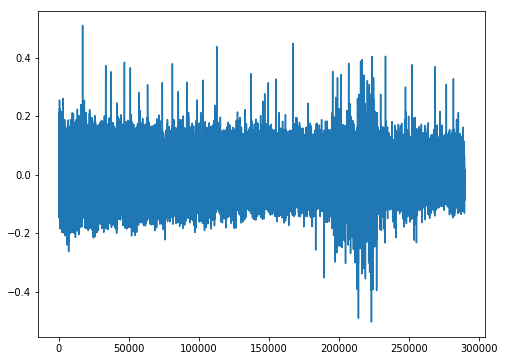

In [13]:
plot(np.nanmean(calibrated[tmask,:], 1))

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


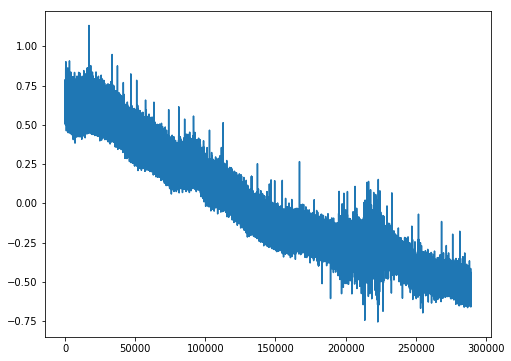

In [12]:
plot(np.nanmean(calibrated[tmask,:]-np.nanmean(calibrated[tmask,:],0), 1))

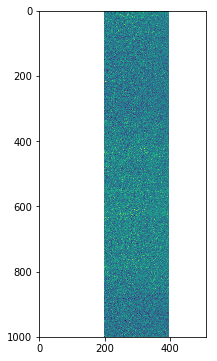

In [14]:
imshow(calibrated[:1000, :])

In [86]:
red = calibrated[tmask, :][:, 200:400]

In [16]:
red.shape

(289385, 200)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


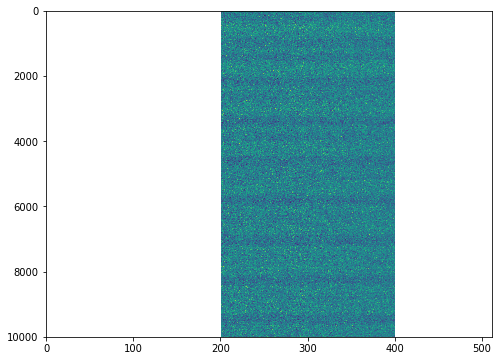

In [17]:
imshow(calibrated[:10000, :]-np.nanmean(calibrated[tmask,:],0), aspect='auto')

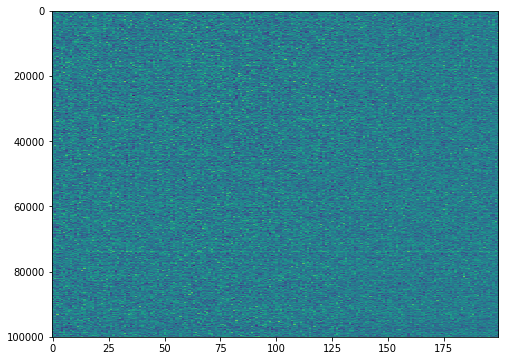

In [18]:
imshow(red[:100000, :], aspect='auto')

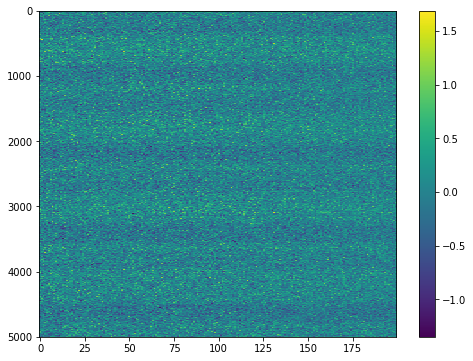

In [22]:
imshow(red[:5000, :], aspect='auto')
colorbar()

In [23]:
from scipy.signal import decimate

In [24]:
y = decimate(red - np.mean(red, 0), 25, axis=0)

/usr/lib64/python2.7/site-packages/scipy/signal/signaltools.py:3402: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


In [87]:
msred = red - np.mean(red, 0)

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

In [30]:
rc('animation', html='html5')

(62.4, 65)

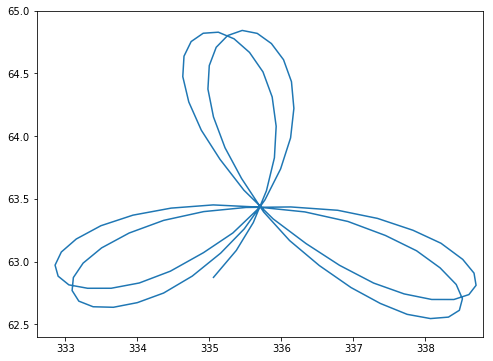

In [79]:
plot(ras[:2500:25], decs[:2500:25])
xlim(332.6, 338.8)
ylim(62.4, 65)

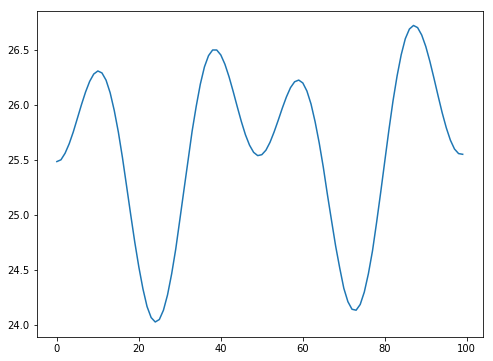

In [32]:
plot(els[:2500:25])

In [50]:
figsize(12, 8)

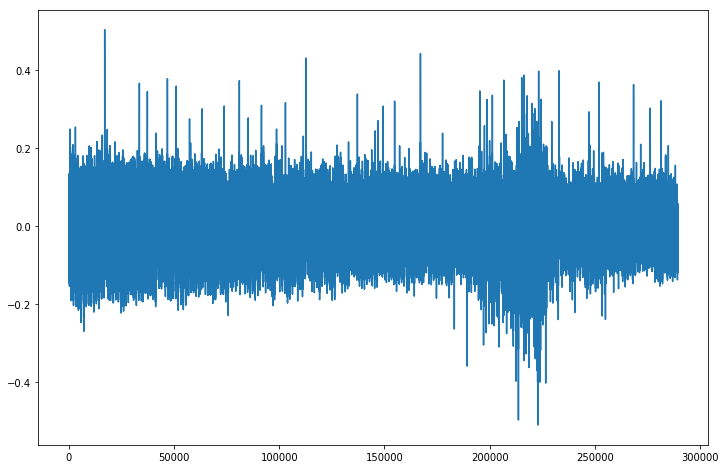

In [74]:
plot(np.mean(msred, 1))

In [94]:
figsize(8, 6)

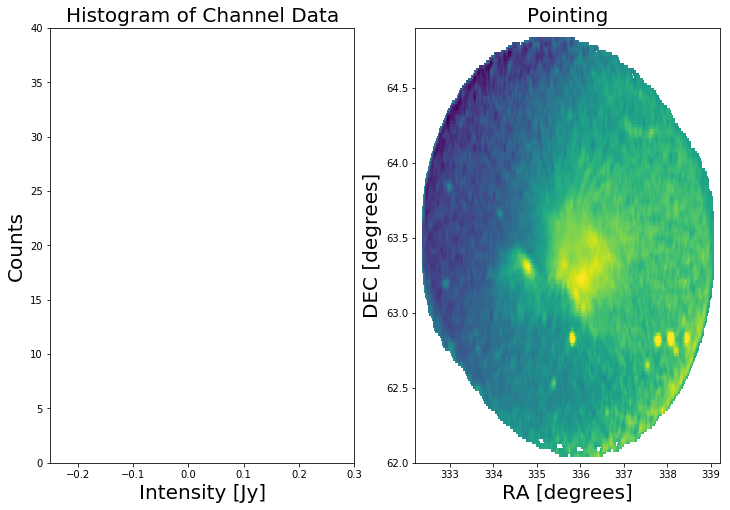

In [154]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].set_xlim(( -0.25, 0.3))
ax[0].set_ylim((0, 40))
ax[0].set_xlabel('Intensity [Jy]', fontsize=20)
ax[0].set_ylabel('Counts', fontsize=20)
ax[0].set_title('Histogram of Channel Data', fontsize=20)

ax[1].set_xlim((332.2, 339.2))
ax[1].set_ylim((62, 64.9))
ax[1].set_xlabel('RA [degrees]', fontsize=20)
ax[1].set_ylabel('DEC [degrees]', fontsize=20)
ax[1].set_title('Pointing', fontsize=20)
qmesh = ax[1].pcolormesh(rabinsc, decbinsc, signal * 1000., vmin=-12, vmax=12)
#qmesh.colorbar()
#fig.colorbar(qmesh.get_cmap())


line, = ax[0].plot([], [], lw=2)
line.set_drawstyle('steps')
line2, = ax[1].plot([], [], color='r', lw=2)

In [155]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line2.set_data([], [])
    return line, line2

In [156]:
# animation function. This is called sequentially
def animate(i):
    counts, bins = np.histogram(y[i], bins=15)
    #line.hist(y[i], bins=20)
    line.set_data(bins[1:], counts)
    line2.set_data(ras[:i*25], decs[:i*25])
    return line, line2

In [161]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=300, interval=100, blit=True)

In [162]:
anim

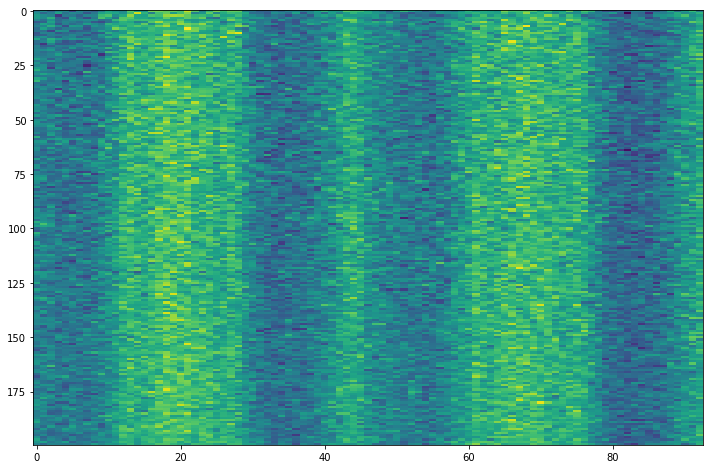

In [64]:
imshow(y[7:100, :].T, aspect='auto')

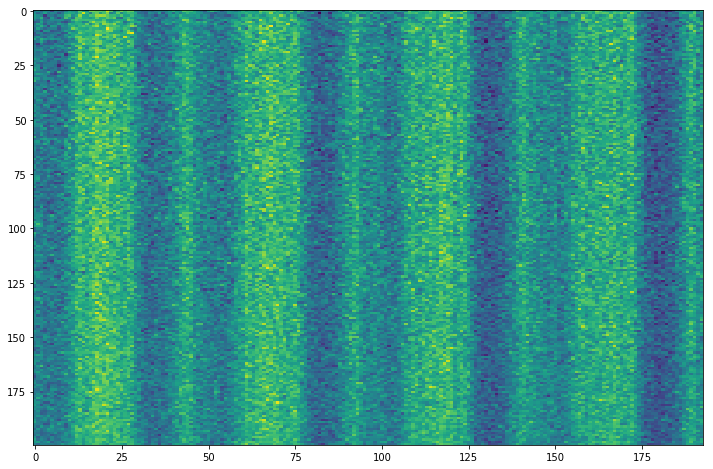

In [65]:
imshow(y[7:200, :].T, aspect='auto')

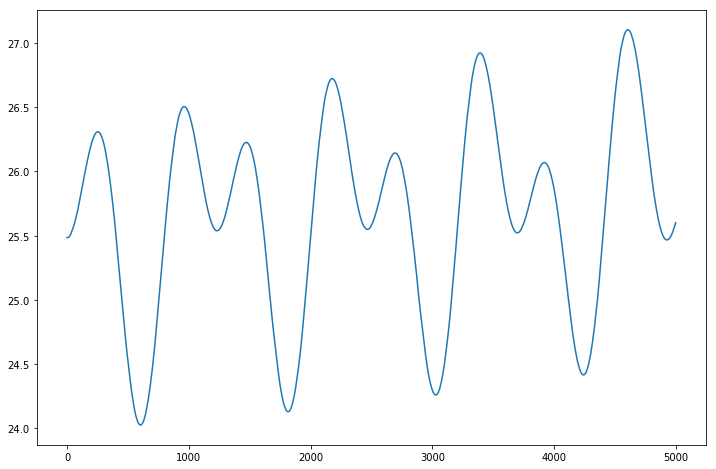

In [66]:
plot(els[:5000])

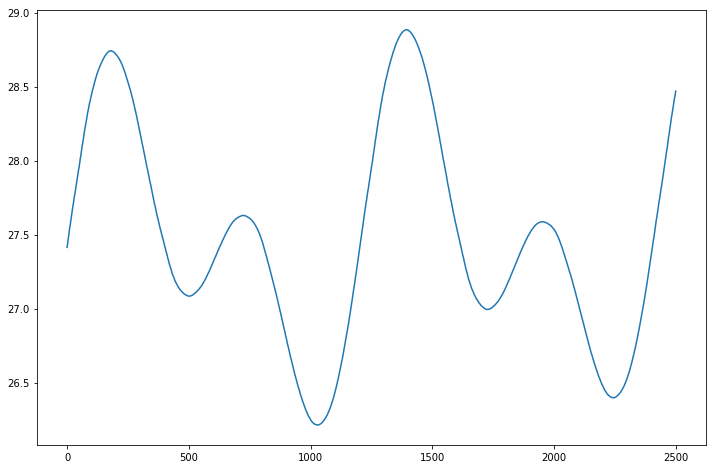

In [67]:
plot(azs[:2500])

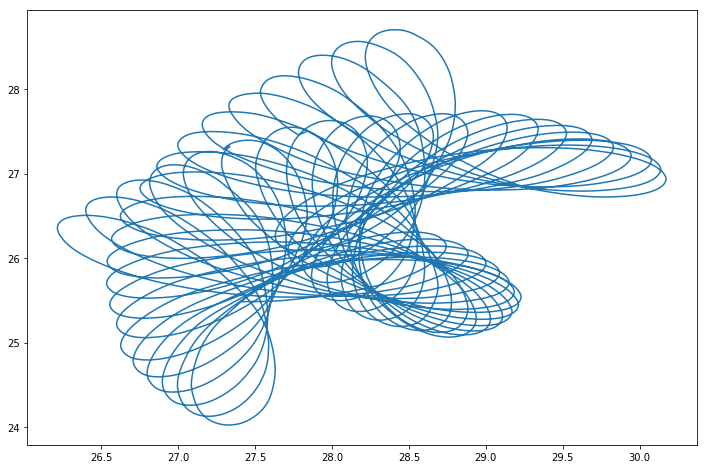

In [68]:
plot(azs[:25000], els[:25000])

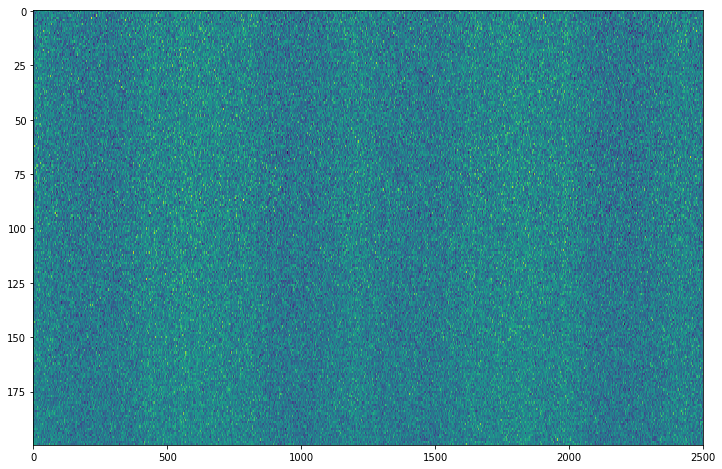

In [69]:
imshow((red[:2500, :]-np.nanmean(red,0)).T, aspect='auto')

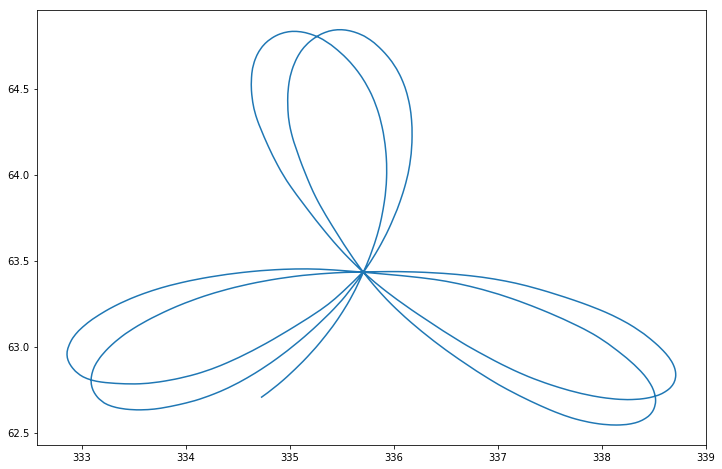

In [70]:
plot(ras[:100*25], decs[:100*25])

In [88]:
session = 5
bank = 'A'

In [128]:
smth = None
pixbeam = 1.
removeplane = False

In [129]:
ras = ra[tmask]
decs = dec[tmask]
calibrated = np.mean(msred, 1)
    
#c = coordinates.SkyCoord(frame='fk5', ra=ras*u.degree, dec=decs*u.degree)
#decs = c.galactic.b.deg
#ras = c.galactic.l.deg
#rc = 107.2
#dc = 5.2

rc = 335.7134
dc = 63.4380

if bank == 'A':
    cfreq = 4.575
elif bank == 'B':
    cfreq = 5.625
elif bank == 'C':
    cfreq = 6.125
elif bank == 'D':
    cfreq = 7.175
beam = 12.6 / cfreq

# units
# beam and pixbeam are in arcminutes
beamarea = np.pi / (4. * np.log(2)) * beam**2
pixelarea = pixbeam**2
units = pixelarea / beamarea

# ras and decs are in degrees 
nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))

datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
mask = hits == 0
signal = np.zeros_like(datamap)
signal[~mask] = datamap[~mask] / hits[~mask] * units

radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)

rmask = radius <= 1.
insidedata = np.zeros_like(calibrated)
insidedata[rmask] = 10.
innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
innerregion = innermap > 0

annulus = (radius >= 80./60.) & (radius <= 2.)
annulus = radius >= 1.
outerdata = np.zeros_like(calibrated)
outerdata[annulus] = 10.
outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
outerregion = outermap > 0

rabinsc = (rabins[1:] + rabins[:-1]) / 2.
decbinsc = (decbins[1:] + decbins[:-1]) / 2.
if removeplane:
    X, Y = np.meshgrid(rabinsc, decbinsc)
    XX = X.flatten()
    YY = Y.flatten()
    Z = signal.flatten()
    masks = ~np.isnan(Z) * ~innerregion.flatten() #* regionregion.flatten()
    data = np.c_[XX[masks], YY[masks], Z[masks]]
    data2 = np.c_[XX, YY, Z]
    A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
    C, _, _, _ = linalg.lstsq(A, data[:, 2])
    res = C[0] * X + C[1] * Y + C[2]
    signal -= res

signal -= np.nanmedian(signal[outerregion])
if smth is None:
    smth = beam
if smth > 0:
    sigma = smth / pixbeam / (2. * np.sqrt(2. * np.log(2)))
    signal = gaussian_filter(signal, sigma)
    shits = gaussian_filter(hits, sigma)
    mask = shits < 1
signal[mask] = np.nan
print np.nansum(signal[innerregion]), np.nanstd(signal[outerregion]) * np.sqrt(innerregion.sum())

35.998954503605006 0.518270598069947


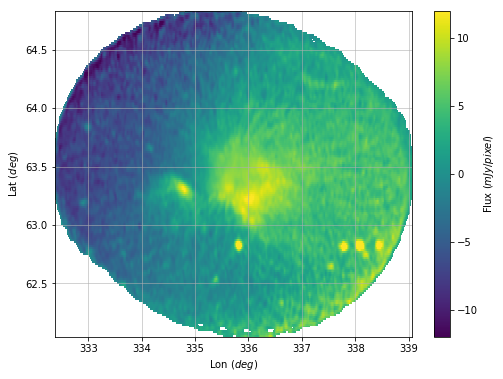

In [130]:
figure()
pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
clim(-12, 12)
cb = colorbar()
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid(alpha=0.7)
#title('$6.2~GHz$')